### Importing libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.sparse import hstack
from scipy.sparse import csr_matrix


### Loading data and EDA

In [30]:
# Load dataset
df = pd.read_csv('input/cosmetics.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Label        1472 non-null   object 
 1   Brand        1472 non-null   object 
 2   Name         1472 non-null   object 
 3   Price        1472 non-null   int64  
 4   Rank         1472 non-null   float64
 5   Ingredients  1472 non-null   object 
 6   Combination  1472 non-null   int64  
 7   Dry          1472 non-null   int64  
 8   Normal       1472 non-null   int64  
 9   Oily         1472 non-null   int64  
 10  Sensitive    1472 non-null   int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 126.6+ KB


In [4]:
df.head()

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,"Algae (Seaweed) Extract, Mineral Oil, Petrolat...",1,1,1,1,1
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,"Galactomyces Ferment Filtrate (Pitera), Butyle...",1,1,1,1,1
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,"Water, Dicaprylyl Carbonate, Glycerin, Ceteary...",1,1,1,1,0
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,"Algae (Seaweed) Extract, Cyclopentasiloxane, P...",1,1,1,1,1
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38,4.1,"Water, Snail Secretion Filtrate, Phenyl Trimet...",1,1,1,1,1


In [5]:
print(df.shape)

(1472, 11)


In [6]:
print(df.describe())

             Price         Rank  Combination          Dry       Normal  \
count  1472.000000  1472.000000   1472.00000  1472.000000  1472.000000   
mean     55.584239     4.153261      0.65625     0.614130     0.652174   
std      45.014429     0.633918      0.47512     0.486965     0.476442   
min       3.000000     0.000000      0.00000     0.000000     0.000000   
25%      30.000000     4.000000      0.00000     0.000000     0.000000   
50%      42.500000     4.300000      1.00000     1.000000     1.000000   
75%      68.000000     4.500000      1.00000     1.000000     1.000000   
max     370.000000     5.000000      1.00000     1.000000     1.000000   

              Oily    Sensitive  
count  1472.000000  1472.000000  
mean      0.607337     0.513587  
std       0.488509     0.499985  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       1.000000     1.000000  
75%       1.000000     1.000000  
max       1.000000     1.000000  


In [7]:
print(df.isnull().sum())

Label          0
Brand          0
Name           0
Price          0
Rank           0
Ingredients    0
Combination    0
Dry            0
Normal         0
Oily           0
Sensitive      0
dtype: int64


In [8]:
data = df.drop_duplicates()  # Remove duplicate rows

In [9]:
total_brands_count = len(df["Brand"].unique())
total_brands_count

116

In [10]:
total_Labels_count = len(df["Label"].unique())
total_Labels_count

6

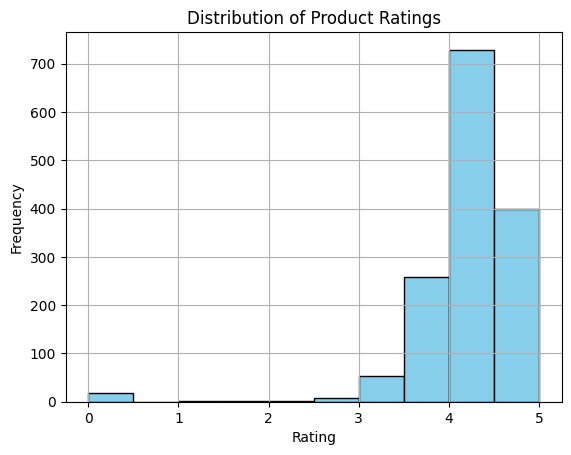

In [11]:
# Plot histogram of product ratings
plt.hist(df["Rank"], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Product Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [12]:
top_5_highest_rank_brands = df.sort_values(by="Rank", ascending=False).head(5)["Brand"]
print("Top 5 highest-ranked brands:", top_5_highest_rank_brands.tolist())

Top 5 highest-ranked brands: ['BIOEFFECT', 'SEPHORA COLLECTION', 'PERRICONE MD', 'FOREO', 'DIOR']


### Recommendation using collaborative-based filtering

In [22]:
# Step 1: Generate synthetic user_id, product_id, and ratings
num_users = 100  # Number of unique users
num_products = len(df)

# Add product_id
df['product_id'] = range(1, num_products + 1)

# Generate synthetic user ratings
np.random.seed(42)
user_ids = np.random.randint(1, num_users + 1, size=num_products * 3)
product_ids = np.random.choice(df['product_id'], size=num_products * 3, replace=True)
ratings = np.random.randint(1, 6, size=num_products * 3)  # Ratings between 1 and 5

# Create user-item ratings DataFrame
ratings_df = pd.DataFrame({
    'user_id': user_ids,
    'product_id': product_ids,
    'rating': ratings
})


# Step 2: Create User-Item Matrix
user_item_matrix = ratings_df.pivot_table(index='user_id', columns='product_id', values='rating', fill_value=0)

# Collaborative Filtering: Item-Based Similarity
item_similarity = cosine_similarity(user_item_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

In [23]:
# Recommendation Function
def recommend_products_item_based(user_id, num_recommendations=5):
    user_ratings = user_item_matrix.loc[user_id]
    liked_products = user_ratings[user_ratings > 0].index.tolist()
    
    # Compute similar product scores
    similar_scores = pd.Series(dtype='float64')
    for product in liked_products:
        similar_products = item_similarity_df[product]
        similar_scores = similar_scores.add(similar_products, fill_value=0)
    
    # Remove already rated products
    similar_scores = similar_scores.drop(index=liked_products, errors='ignore')
    recommendations = similar_scores.sort_values(ascending=False).head(num_recommendations)
    
    return recommendations.index

In [24]:
# Step 3: RMSE Calculation
def calculate_rmse():
    actual_ratings = []
    predicted_ratings = []
    
    for user_id in user_item_matrix.index:
        user_ratings = user_item_matrix.loc[user_id]
        liked_products = user_ratings[user_ratings > 0].index.tolist()
        
        for product in liked_products:
            # Predict rating based on similarity
            similar_products = item_similarity_df[product]
            predicted_rating = (user_ratings[liked_products] * similar_products[liked_products]).sum() / similar_products[liked_products].sum()
            predicted_ratings.append(predicted_rating)
            actual_ratings.append(user_ratings[product])
    
    # RMSE between actual and predicted ratings
    return sqrt(mean_squared_error(actual_ratings, predicted_ratings))

# Step 4: Run Recommendation and Evaluate
sample_user = user_ids[0]
recommended_product_ids = recommend_products_item_based(sample_user)
recommended_products = df[df['product_id'].isin(recommended_product_ids)]

print(f"Recommended products for User ID {sample_user}:\n")
print(recommended_products[['product_id', 'Name', 'Brand']])

# Calculate RMSE
rmse = calculate_rmse()
print(f"\nRMSE for Collaborative Filtering: {rmse:.3f}")

Recommended products for User ID 52:

      product_id                                               Name  \
205          206  Moisture Surge Hydrating Supercharged Concentrate   
681          682                Water Drench Hyaluronic Cloud Serum   
753          754                  Bio-Performance LiftDynamic Serum   
1016        1017                                   Glow Addict Mask   
1423        1424             Flawless Skin Daily Face Shield SPF 40   

                  Brand  
205            CLINIQUE  
681   PETER THOMAS ROTH  
753            SHISEIDO  
1016              FOREO  
1423      LAURA MERCIER  

RMSE for Collaborative Filtering: 1.296


### Recommendation using content-based filtering

In [25]:
def recommend_cosmetics(skin_type, label_filter, rank_filter, brand_filter, price_range, ingredient_input=None, num_recommendations=10):
    recommended_products = df[df[skin_type] == 1]
    
    if label_filter != 'All':
        recommended_products = recommended_products[recommended_products['Label'] == label_filter]
    
    recommended_products = recommended_products[
        (recommended_products['Rank'] >= rank_filter[0]) & 
        (recommended_products['Rank'] <= rank_filter[1])
    ]
    
    if brand_filter != 'All':
        recommended_products = recommended_products[recommended_products['Brand'] == brand_filter]
    
    recommended_products = recommended_products[
        (recommended_products['Price'] >= price_range[0]) & 
        (recommended_products['Price'] <= price_range[1])
    ]

    if ingredient_input:
        vectorizer = TfidfVectorizer(stop_words='english')
        tfidf_matrix = vectorizer.fit_transform(df['Ingredients'])
        input_vec = vectorizer.transform([ingredient_input])
        cosine_similarities = cosine_similarity(input_vec, tfidf_matrix).flatten()
        recommended_indices = cosine_similarities.argsort()[-num_recommendations:][::-1]
        ingredient_recommendations = df.iloc[recommended_indices]
        recommended_products = recommended_products[recommended_products.index.isin(ingredient_recommendations.index)]
    
    return recommended_products.sort_values(by=['Rank']).head(num_recommendations)
    

In [26]:
# Test with relaxed filters
recommended_products = recommend_cosmetics(
    skin_type='Oily',
    label_filter='All',
    rank_filter=(4,5),
    brand_filter='All',
    price_range=(0, 5000),
    ingredient_input=None,
    num_recommendations=5
)
print(recommended_products)

      Label               Brand                                        Name  \
861       2  KIEHL'S SINCE 1851    Calendula & Aloe Soothing Hydration Mask   
1099      1               FRESH  Black Tea Firming and De-Puffing Eye Cream   
1076      2            CLINIQUE      Pep-Start Double Bubble Purifying Mask   
374       0            CAUDALIE                    Micellar Cleansing Water   
1042      2     KATE SOMERVILLE         Wrinkle Warrior® Pink Plumping Mask   

      Price  Rank                                        Ingredients  \
861      45   4.0  Water, Glycerin, Aloe Barbadensis Leaf Juice, ...   
1099     68   4.0  Water, Glycerin, Butylene Glycol, Squalane, Pr...   
1076     24   4.0  Water , Disiloxane , Cocamidopropyl Betaine , ...   
374      14   4.0  Water, Glycerin*, Poloxamer 188, Vitis Vinifer...   
1042     56   4.0  Water, Propanediol, Glycerin, Pyrus Malus (App...   

      Combination  Dry  Normal  Oily  Sensitive  \
861             1    1       1     1     